In [1]:
# ================================================
# 必要なライブラリのインポートと表示設定
# ================================================

# 数値計算に使うライブラリ
import numpy as np
import pandas as pd

# グラフを描画するライブラリ
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set()  # Seabornのデフォルトスタイルを有効化（見やすいグラフに）

# データ読み込み
import statsmodels.api as sm

# sktime：グラフ描画ユーティリティ
from sktime.utils.plotting import plot_series

# sktime：予測モデル
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster

# sktime：予測の評価指標
from sktime.performance_metrics.forecasting import (
    mean_absolute_scaled_error,
    MeanAbsoluteError,
    mean_absolute_percentage_error,
    mean_absolute_error,
)

# sktime：予測評価・モデル選択
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
)
from sktime.forecasting.model_evaluation import evaluate

# sktime：データ変換（季節調整・トレンド除去・差分など）
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.transformations.series.difference import Differencer
from sktime.transformations.series.boxcox import LogTransformer

# sktime：パイプライン構築
from sktime.forecasting.compose import TransformedTargetForecaster, MultiplexForecaster
from sktime.transformations.compose import OptionalPassthrough

# --------------------------------
# グラフの日本語表記設定
# --------------------------------
from matplotlib import rcParams

rcParams["font.family"] = "IPAexGothic"
rcParams["font.sans-serif"] = "Meiryo"  # 日本語を「メイリオ」で表示

# --------------------------------
# DataFrame の全角文字（日本語など）の出力を整形
# --------------------------------
pd.set_option("display.unicode.east_asian_width", True)
# これにより、DataFrameを print したときに
# 全角文字がきれいに整列して表示される

In [2]:
# 表示設定
np.set_printoptions(linewidth=60)
pd.set_option("display.width", 80)

from matplotlib.pylab import rcParams

rcParams["figure.figsize"] = 8, 4

In [3]:
# 飛行機乗客数データの読み込み
air_passengers = sm.datasets.get_rdataset("AirPassengers").data

# 日付インデックスの作成(PeriodIndex)
date_index = pd.period_range(start="1949-01", periods=len(air_passengers), freq="M")
air_passengers.index = date_index

# 不要な時間ラベルの削除
air_passengers = air_passengers.drop(air_passengers.columns[0], axis=1)

# 結果の確認
print(air_passengers.head(3))

         value
1949-01    112
1949-02    118
1949-03    132


<Axes: >

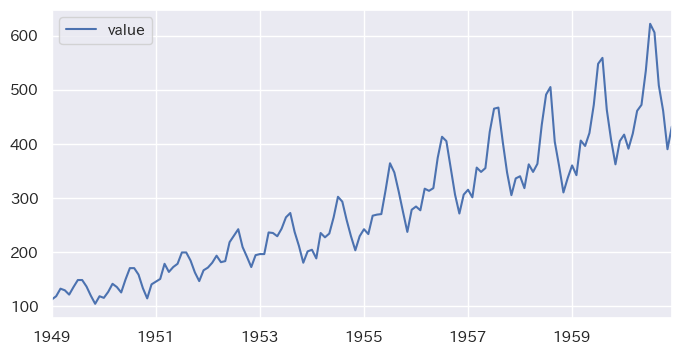

In [4]:
# 参考：素朴にpandasのplot関数を適用

# グラフサイズの指定
fig, ax = plt.subplots(figsize=(8, 4))

# 折れ線グラフを描く
air_passengers.plot(ax=ax)

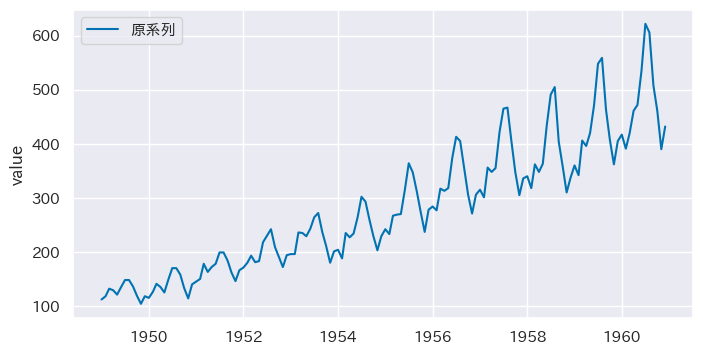

In [5]:
# 参考：sktimeのplot_series関数を利用

# ==============================
# 飛行機乗客数データを折れ線グラフで可視化
# ==============================

# sktimeの便利な可視化関数plot_seriesを利用して描画
# labels：凡例に表示するラベル
# markers：データ点にマーカーを付ける（''で非表示）
fig, ax = plot_series(air_passengers, labels=["原系列"], markers=[""])

# グラフサイズの指定（横8インチ × 縦4インチ）
fig.set_size_inches(8, 4)

# axはmatplotlibのAxesオブジェクトで、
# さらにタイトルや軸ラベルを追加することも可能
# 例: ax.set_title('AirPassengers データの時系列')

In [6]:
# ===============================================
# 訓練データとテストデータへの分割
# ===============================================
# temporal_train_test_split：
#   時系列データを「過去（train）」と「未来（test）」に分割する関数。
#   ランダムではなく、**時間順**に分ける点が重要。
#
# test_size=36：
#   36か月（＝3年分）をテストデータとして確保。
#   残りは訓練データとしてモデルの学習に使用する。
#
# test.index：
#   分割後のテストデータのインデックス（日付）を確認。
# ===============================================

train, test = temporal_train_test_split(air_passengers, test_size=36)
test.index

PeriodIndex(['1958-01', '1958-02', '1958-03', '1958-04', '1958-05', '1958-06',
             '1958-07', '1958-08', '1958-09', '1958-10', '1958-11', '1958-12',
             '1959-01', '1959-02', '1959-03', '1959-04', '1959-05', '1959-06',
             '1959-07', '1959-08', '1959-09', '1959-10', '1959-11', '1959-12',
             '1960-01', '1960-02', '1960-03', '1960-04', '1960-05', '1960-06',
             '1960-07', '1960-08', '1960-09', '1960-10', '1960-11', '1960-12'],
            dtype='period[M]')

In [7]:
# ===============================================
# 予測期間（Forecasting Horizon）の設定
# ===============================================
# fh（Forecasting Horizon）とは：
#   何ステップ先まで予測するかを指定するベクトル。
#   sktimeの予測器（Forecaster）は、fhに基づいて未来の期間を決定する。
#
# np.arange(1, len(test) + 1)：
#   テストデータの長さと同じだけ「1, 2, 3, ...」という
#   予測ステップ番号を生成。
#   ここでは、テストデータが36か月分なので fh = [1, 2, ..., 36]
#   となり、「36か月先まで予測する」という意味になる。
# ===============================================

fh = np.arange(1, len(test) + 1)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36])

In [8]:
# ===============================================
# ナイーブ予測（Naive Forecast）の実装
# ===============================================
# NaiveForecaster(strategy='last')：
#   sktime の単純予測モデル。
#   - strategy='last'：直近の観測値をそのまま次の予測値とする
#     （＝「持続予測」 persistence model）。
#
# fit(train)：
#   訓練データ（train）を使ってモデルを当てはめる。
#   ※ナイーブ予測では「最後の値」を記録するだけ。
#
# predict(fh)：
#   fh（予測期間）で指定した範囲（ここでは36か月）について
#   予測値を生成する。
# ===============================================

naive_forecaster = NaiveForecaster(strategy="last")  # モデル定義
naive_forecaster.fit(train)  # 学習
naive_pred = naive_forecaster.predict(fh)  # 予測

In [9]:
# ===============================================
# fit_predict() による一括実行
# ===============================================
# fit_predict():
#   ・モデルの学習（fit）と予測（predict）を1ステップで実施する関数。
#   ・手軽に試すときやベースライン確認に便利。
#
# 出力：
#   予測値がSeriesとして返される（ここでは最初の3件を表示）。
# ===============================================

print(naive_forecaster.fit_predict(y=train, fh=fh).head(3))

         value
1958-01  336.0
1958-02  336.0
1958-03  336.0


In [10]:
# ===============================================
# 季節性を考慮したナイーブ予測（季節ナイーブ法）
# ===============================================
# NaiveForecaster(strategy='last', sp=12)
#   ・strategy='last'：直前の観測値をそのまま次期の予測値に使う。
#   ・sp=12：季節周期（seasonal_period）を12（＝12か月）と指定。
#              → 1年前（同じ月）の値を予測値として利用。
#
# fit(train)
#   ・訓練データ（train）を使って内部構造をセット。
#     ※ナイーブ法の場合、複雑な学習は不要。
#
# predict(fh)
#   ・fh（予測期間）に対して未来の値を予測。
# ===============================================

s_naive_forecaster = NaiveForecaster(strategy="last", sp=12)
s_naive_forecaster.fit(train)
s_naive_pred = s_naive_forecaster.predict(fh)

In [11]:
# ===============================================
# 平均値予測（Mean Forecast）
# ===============================================
# NaiveForecaster(strategy='mean')
#   ・strategy='mean'：訓練データ全体の平均値を
#                        すべての将来時点の予測値として使用。
#   ・この方法はトレンドや季節性を無視し、
#     「過去平均が今後も続く」と仮定する単純モデル。
#
# fit(train)
#   ・訓練データから平均値を計算して記憶する。
#
# predict(fh)
#   ・fh（予測期間）にわたって、一定の平均値を出力する。
# ===============================================

mean_forecaster = NaiveForecaster(strategy="mean")
mean_forecaster.fit(train)
mean_pred = mean_forecaster.predict(fh)

In [12]:
# ===============================================
# 移動平均予測（Moving Average Forecast）
# ===============================================
# NaiveForecaster(strategy='mean', window_length=12)
#   ・直近12期間（1年分）のデータ平均を使って予測するモデル。
#   ・過去1年の平均値を「次の期間の予測値」とみなす。
#   ・トレンドをならして、季節的変動を平滑化する効果がある。
#
# fit(train)
#   ・訓練データを基に、直近12か月分の移動平均を計算。
#
# predict(fh)
#   ・fh（予測期間）にわたって、直近12か月平均を繰り返し出力。
# ===============================================

ma_forecaster = NaiveForecaster(strategy="mean", window_length=12)
ma_forecaster.fit(train)
ma_pred = ma_forecaster.predict(fh)

In [13]:
# ===============================================
# ドリフト予測（Drift Forecast）
# ===============================================
# NaiveForecaster(strategy='drift')
#   ・最初と最後の観測値を結ぶ「直線（トレンド）」を延長して予測するモデル。
#   ・つまり「過去の平均的な増加・減少の傾き（ドリフト）」が
#     将来も続くと仮定して予測する。
#
# fit(train)
#   ・訓練データの最初と最後の値から傾きを算出。
#
# predict(fh)
#   ・算出した傾きに基づき、将来時点まで直線的に外挿して予測。
# ===============================================

drift_forecaster = NaiveForecaster(strategy="drift")
drift_forecaster.fit(train)
drift_pred = drift_forecaster.predict(fh)

In [14]:
# ===============================================
# クロスバリデーション（時系列用CV）の設定
# ===============================================
# ExpandingWindowSplitter：
#   ・時系列データにおける交差検証（CV）を行うための分割クラス。
#   ・過去のデータを「徐々に増やしながら」学習し、
#     1期先（fh=1）を毎回予測して精度を評価する。
#
# パラメータ：
#   fh=1               → 1ステップ先の予測を行う。
#   initial_window=1   → 最初の訓練データ点数は1（最初の1点から開始）。
#   step_length=1      → 各ステップごとに1点ずつ訓練データを増やす。
#
# つまり：
#   1点で学習 → 次の1点を予測 → 2点で学習 → 次の1点を予測 → … と繰り返す。
#   時系列データの「逐次学習・予測」を再現できる設定である。
# ===============================================

cv = ExpandingWindowSplitter(fh=1, initial_window=1, step_length=1)

In [15]:
# ===============================================
# クロスバリデーション（CV）の実行
# ===============================================
# evaluate():
#   ・指定したモデルとデータで時系列CVを自動的に実行する関数。
#   ・各ステップの予測と評価指標をまとめて返す。
#
# 引数：
#   forecaster = naive_forecaster   → 使用する予測モデル
#   cv         = cv                 → 時系列CVの分割ルール（ExpandingWindowSplitter）
#   y          = train              → 学習に使う時系列データ
#   scoring    = MeanAbsoluteError()→ 評価指標（ここでは平均絶対誤差 MAE）
#
# 出力：
#   cv_df：各分割ごとの予測結果・誤差・インデックスなどを含むDataFrame。
#   ここではそのうち最初の3件を表示して確認している。
# ===============================================

cv_df = evaluate(
    forecaster=naive_forecaster, cv=cv, y=train, scoring=MeanAbsoluteError()
)

print(cv_df.head(3))

   test_MeanAbsoluteError  fit_time  pred_time  len_train_window   cutoff
0                     6.0  0.002892   0.013269                 1  1949-01
1                    14.0  0.001180   0.003390                 2  1949-02
2                     3.0  0.000958   0.002753                 3  1949-03


In [16]:
# ===============================================
# クロスバリデーション（CV）結果の集計
# ===============================================
# cv_df.iloc[:, 0] は、各分割ステップにおける
# 1時点先予測の MAE（平均絶対誤差）を取り出している。
#
# mean() によって、その平均値を計算。
# → モデル全体としての平均的な予測誤差を確認できる。
# ===============================================

cv_df.iloc[:, 0].mean()

20.317757009345794

In [17]:
# ===============================================
# MASE（Mean Absolute Scaled Error）で用いる基準誤差の確認
# ===============================================
# 「naive_error」とは：
#   → 1期前の値（持続予測）との差の絶対値の平均。
#   → MASE の分母として用いられる「基準誤差」。
#
# 下記の式では、訓練データ train の中で
#   ・当期（1949-02〜1957-12）と
#   ・1期前（1949-01〜1957-11）
# の値の差を取り、その絶対値の平均を算出している。
#
# 結果的に、これは「持続予測の1期先誤差の平均」＝naive_error に一致する。
# ===============================================

np.abs(train["1949-02":"1957-12"].values - train["1949-01":"1957-11"].values).mean()

20.317757009345794

In [18]:
# ===============================================
# クロスバリデーション（CV）の設定と実行（12ステップ先予測）
# ===============================================
# ExpandingWindowSplitter():
#   ・時系列データを、過去から順に「拡張しながら」訓練・検証に分割する方法。
#
# 引数：
#   fh=np.arange(1,13)
#       → 1〜12ステップ先（＝1年分）の予測を対象とする。
#   initial_window=24
#       → 最初の24時点を訓練データとして使用（2年分）。
#   step_length=12
#       → 検証のたびに12時点（1年分）ずつ訓練データを拡張する。
#
# evaluate():
#   ・指定した forecaster（モデル）と CV ルールに従い、
#     複数ステップ先予測を自動で繰り返し評価。
#   ・ここでは MAE（Mean Absolute Error）を指標に採用。
#   ・return_data=True により、各ステップの
#     予測値・実測値も結果に含める。
#
# 出力：
#   cv_df: 各分割ステップにおける MAE と対応する予測・実測データが格納された DataFrame。
# ===============================================

cv = ExpandingWindowSplitter(fh=np.arange(1, 13), initial_window=24, step_length=12)

cv_df = evaluate(
    forecaster=naive_forecaster,
    cv=cv,
    y=train,
    scoring=MeanAbsoluteError(),
    return_data=True,
)

In [19]:
# ===============================================
# 12時点先予測（1年先予測）の平均MAEを算出
# ===============================================
# cv_df.iloc[:, 0]:
#   evaluate() の結果 DataFrame（cv_df）の最初の列に、
#   各CV分割（fold）で得られた MAE（平均絶対誤差）が格納されている。
#
# mean():
#   それらの MAE を平均することで、
#   「モデル全体としての12ステップ先予測誤差の平均値」を求める。
#
# 結果：
#   → モデル（ここでは NaiveForecaster）の長期予測精度を
#      単一指標として評価できる。
# ===============================================

cv_df.iloc[:, 0].mean()

43.511904761904766

In [20]:
# ===============================================
# クロスバリデーション（CV）の結果の詳細を確認
# ===============================================
# evaluate() の出力（cv_df）は、各分割ステップ（fold）ごとの
# 予測結果と評価指標（ここでは MAE）をまとめた DataFrame。
#
# 含まれる主な情報：
#   - test_fold      : 各CV分割の番号
#   - test_start/end : 検証に使われた期間（時系列の範囲）
#   - MAE            : その分割における平均絶対誤差
#   - y_pred         : 予測された値（return_data=True の場合）
#   - y_test         : 実際の値（同上）
#
# head(3) で最初の3分割分を確認し、
# CVが正しく実行されているかを検証できる。
# ===============================================

cv_df.head(3)

,test_MeanAbsoluteError,fit_time,pred_time,len_train_window,cutoff,y_train,y_test,y_pred
0,30.166667,0.002245,0.008659,24,1950-12,value 1949-01 112 1949-02 118 1...,value 1951-01 145 1951-02 150 1...,value 1951-01 140.0 1951-02 140.0 1...
1,31.000000,0.003514,0.007164,36,1951-12,value 1949-01 112 1949-02 118 1...,value 1952-01 171 1952-02 180 1...,value 1952-01 166.0 1952-02 166.0 1...
2,33.333333,0.001350,0.007661,48,1952-12,value 1949-01 112 1949-02 118 1...,value 1953-01 196 1953-02 196 1...,value 1953-01 194.0 1953-02 194.0 1...


Text(0, 0.5, '乗客数')

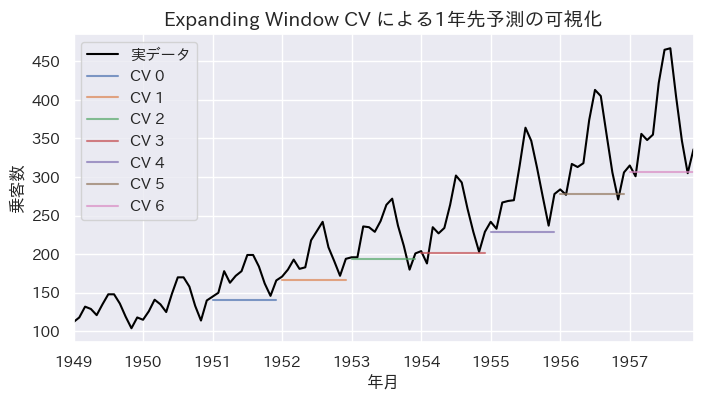

In [21]:
# ===============================================
# クロスバリデーション（CV）各ステップの予測結果を可視化
# ===============================================

# グラフの描画設定
fig, ax = plt.subplots(figsize=(8, 4))  # 図のサイズを指定（8x4インチ）

# 訓練データ（実際の観測値）の折れ線グラフを描く
train.plot(ax=ax, color="black", label="実データ")

# 各CV分割（fold）で得られた予測値を重ねてプロット
for i in np.arange(0, cv_df.shape[0]):
    # evaluate(..., return_data=True) により y_pred が保存されている
    cv_df["y_pred"].iloc[i].plot(ax=ax, alpha=0.7)

# 凡例を設定
# "actual" → 実測値
# "CV 0", "CV 1", ... → 各分割の予測結果
plt.legend(["実データ"] + [f"CV {i}" for i in range(cv_df.shape[0])])

# タイトルと軸ラベルの追加（任意）
plt.title("Expanding Window CV による1年先予測の可視化", fontsize=14)
plt.xlabel("年月")
plt.ylabel("乗客数")

# ===============================================
# 解説：
# 各折れ線は「特定時点までで学習 → 次の12ヶ月を予測」した結果。
# 分割ごとに訓練データが広がっていく様子を視覚的に確認できる。
# ===============================================

In [22]:
# ==========================================================
# 予測パイプライン（季節調整 → トレンド除去 → 予測）を構築
# ==========================================================

# TransformedTargetForecaster は、前処理と予測器を連結できるクラス。
# 下から順に、目的変数（y）に対して以下の処理を順番に適用する：
# ① 季節成分の除去（Deseasonalizer）
# ② トレンド成分の除去（Detrender）
# ③ 残差に対して単純な予測（NaiveForecaster）

pipe_forecaster_1 = TransformedTargetForecaster(
    [
        # ------------------------------
        # (1) 季節成分の除去
        # ------------------------------
        # モデル: 乗法型（multiplicative）
        # 周期: 12（= 12ヶ月ごとに繰り返す季節性）
        ("deseasonalize", Deseasonalizer(model="multiplicative", sp=12)),
        # ------------------------------
        # (2) トレンド成分の除去
        # ------------------------------
        # 1次多項式（線形トレンド）でフィッティングし、除去する
        (
            "detrend",
            Detrender(
                forecaster=PolynomialTrendForecaster(degree=1), model="multiplicative"
            ),
        ),
        # ------------------------------
        # (3) 残差系列に対して予測を行う
        # ------------------------------
        # 「直近の値（last）」を次の時点の予測とするナイーブ法
        ("forecast", NaiveForecaster(strategy="last")),
    ]
)

# ==========================================================
# 解説：
# ・このようにパイプライン化することで、トレンド・季節の影響を
#   自動的に除去した上で予測を行うことができる。
# ・sktimeでは前処理（Deseasonalizer, Detrender）も「変換器」として
#   統一的に扱えるため、柔軟なモデル構築が可能となる。
# ==========================================================

In [23]:
# ==========================================================
# パイプラインモデルの学習・予測・評価
# ==========================================================

# ------------------------------
# (1) データへの当てはめ（学習）
# ------------------------------
# train データに対して、以下の順に処理を適用：
#   ① 季節成分の除去（Deseasonalizer）
#   ② トレンド成分の除去（Detrender）
#   ③ 残差系列に対してナイーブ予測（NaiveForecaster）
pipe_forecaster_1.fit(train)

# ------------------------------
# (2) 予測の実施
# ------------------------------
# fh は "forecasting horizon"（予測の先の期間）を表す。
# ここではテストデータの期間分（36か月）を予測。
pipe_pred_1 = pipe_forecaster_1.predict(fh)

# ------------------------------
# (3) 予測精度の算出（MAE）
# ------------------------------
# 平均絶対誤差（Mean Absolute Error）を用いて評価。
# 値が小さいほど、予測精度が高いことを意味する。
mae_value = mean_absolute_error(test, pipe_pred_1)

print("平均絶対誤差（MAE）:", round(mae_value, 3))

# ==========================================================
# 解説：
# ・sktimeのパイプラインを使うことで、季節調整やトレンド除去を
#   明示的に行わずに、統一的に学習・予測・評価を行える。
# ・この手法は、季節性・トレンドを持つデータに対して
#   「単純なナイーブ予測」よりも高精度になることが多い。
# ==========================================================

平均絶対誤差（MAE）: 23.601


In [24]:
# ==========================================================
# 時系列クロスバリデーション（CV）による性能評価
# ==========================================================

# ------------------------------
# (1) クロスバリデーション設定
# ------------------------------
# ExpandingWindowSplitter：
#   ・初期の訓練データ数：24（＝2年分）
#   ・予測ステップ数：12（＝1年先まで予測）
#   ・step_length=12 → 毎回1年分ずつ訓練データを拡張して再学習
#
# 例：
#   1回目 → 1949-1950 で学習し、1951年を予測
#   2回目 → 1949-1951 で学習し、1952年を予測
#   ...
cv = ExpandingWindowSplitter(
    fh=np.arange(1, 13),  # 予測期間：12か月先
    initial_window=24,  # 初期ウィンドウ：24か月
    step_length=12,  # ステップ長：12か月
)

# ------------------------------
# (2) クロスバリデーションの実行
# ------------------------------
# evaluate():
#   ・指定した forecaster（パイプライン）を使って
#     各分割ごとに予測を実施
#   ・MAE（平均絶対誤差）で性能を評価
cv_df = evaluate(
    forecaster=pipe_forecaster_1, cv=cv, y=train, scoring=MeanAbsoluteError()
)

# ------------------------------
# (3) 評価指標の平均値（MAE）を算出
# ------------------------------
mean_mae = cv_df.iloc[:, 0].mean()
print("12か月先予測の平均MAE：", round(mean_mae, 3))

# ==========================================================
# 解説：
# ・ExpandingWindowSplitter により、
#   「時間の流れを保った検証」が可能（未来情報のリークを防ぐ）。
# ・この方法は時系列モデルの汎化性能評価において
#   最も信頼性の高い検証手法の一つである。
# ==========================================================

12か月先予測の平均MAE： 11.811


In [25]:
# ==========================================================
# 差分を用いたパイプライン予測（季節性対応ナイーブ法）
# ==========================================================

# ------------------------------
# (1) モデル構成の指定
# ------------------------------
# TransformedTargetForecaster：
#   ・時系列データの前処理から予測までを一括で管理できるクラス。
#
# このパイプラインでは次の処理を順番に実行する：
#   ① 1階差分（Differencer）を適用してトレンドを除去
#      → データの非定常性を軽減（ドリフトを取り除く）
#   ② 季節性を考慮したナイーブ予測（sp=12）
#      → 1年前の値をそのまま次年の予測値として使用
#
pipe_forecaster_2 = TransformedTargetForecaster(
    [
        ("transform", Differencer(lags=[1])),  # 差分変換（トレンド除去）
        ("forecast", NaiveForecaster(strategy="last", sp=12)),  # 季節ナイーブ予測
    ]
)

# ------------------------------
# (2) 学習（fit）
# ------------------------------
pipe_forecaster_2.fit(train)

# ------------------------------
# (3) 予測（predict）
# ------------------------------
pipe_pred_2 = pipe_forecaster_2.predict(fh)

# ------------------------------
# (4) 予測精度評価（MAE）
# ------------------------------
mae_result = mean_absolute_error(test, pipe_pred_2)
print("差分 + 季節ナイーブ予測 の MAE：", round(mae_result, 3))

# ==========================================================
# 解説：
# ・Differencer により「非定常性（トレンド成分）」を除去することで、
#   モデルが周期性（季節変動）のみに集中して予測できる。
# ・sp=12 により、月次データで1年周期の季節性を明示的に考慮。
# ・この構成は「単純だが堅牢」なベースラインモデルとして有用。
# ==========================================================

差分 + 季節ナイーブ予測 の MAE： 17.806


In [26]:
# ==========================================================
# クロスバリデーションによる予測性能の検証（MAE平均）
# ==========================================================

# ExpandingWindowSplitter(cv) を用いて時系列CVを実行。
# 各ステップで「12時点先予測」を行い、
# 差分 + 季節ナイーブ予測モデル（pipe_forecaster_2）の汎化性能を評価。

mean_cv_mae = (
    evaluate(
        forecaster=pipe_forecaster_2,  # モデル（パイプライン）
        cv=cv,  # クロスバリデーション設定（12ステップずつ拡張）
        y=train,  # 訓練データ
        scoring=MeanAbsoluteError(),  # 評価指標（平均絶対誤差）
    )
    .iloc[:, 0]
    .mean()  # 各foldのMAEの平均を算出
)

print("CVによる平均MAE：", round(mean_cv_mae, 3))

# ----------------------------------------------------------
# 📘 解説：
# ・ExpandingWindowSplitterにより、時間の経過とともに訓練データを拡大し、
#   常に「過去 → 未来」の順序を守って評価できる。
# ・iloc[:, 0].mean() は、各分割（fold）のMAEを平均した値。
#   これが時系列CVでのモデル安定性・予測精度の代表値となる。
# ==========================================================

CVによる平均MAE： 11.131


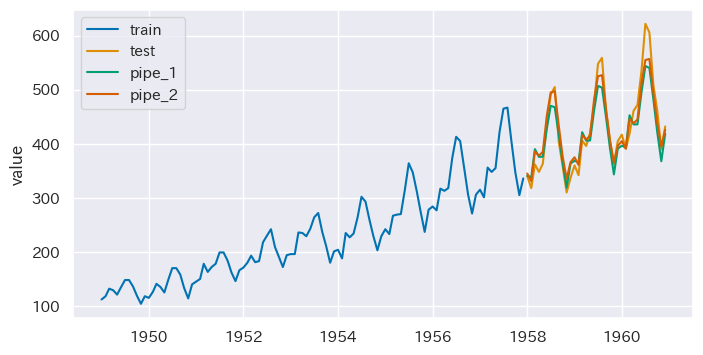

In [27]:
# ==========================================================
# 予測結果の可視化
# ==========================================================
# sktime の plot_series() を利用して、
# 訓練データ・テストデータ・2種類のモデルの予測結果を
# 1つの折れ線グラフ上に描画する。
# ----------------------------------------------------------

fig, ax = plot_series(
    train,
    test,  # 訓練データ・テストデータ
    pipe_pred_1,
    pipe_pred_2,  # 2つのパイプラインモデルの予測値
    labels=["train", "test", "pipe_1", "pipe_2"],  # 凡例の設定
    markers=np.tile("", 4),  # マーカーを非表示にする（折れ線のみ）
)

# グラフのサイズを指定
fig.set_size_inches(8, 4)

# ----------------------------------------------------------
# 📘 解説：
# ・`pipe_1`：季節調整 + トレンド除去 + ナイーブ予測 のモデル
# ・`pipe_2`：差分化 + 季節ナイーブ予測 のモデル
#
# これにより、どちらの前処理・モデル構成が
# テスト期間においてより実データに近い挙動を示すか
# 直感的に比較できる。
# ==========================================================

In [28]:
# ==========================================================
# ハイパーパラメータ探索（Grid Search）による持続予測モデルの最適化
# ==========================================================
# NaiveForecaster（ナイーブ予測）をベースに、
# 季節周期（sp）の値を 1〜12 の範囲でグリッドサーチする。
#
# 目的：最も予測誤差（MAE）が小さくなる季節周期を選択する。
# ----------------------------------------------------------

# 持続予測モデルの定義（前回値をそのまま予測）
naive_forecaster = NaiveForecaster(strategy="last", sp=1)

# ハイパーパラメータ候補
# sp: "seasonal periodicity"（季節周期）
#     例: sp=12 → 12ヶ月周期の季節性を仮定
param_grid = {"sp": np.arange(1, 13)}

# グリッドサーチによる最適化
best_naive_forecaster = ForecastingGridSearchCV(
    forecaster=naive_forecaster,  # モデル本体
    param_grid=param_grid,  # 検索するパラメータの組み合わせ
    cv=cv,  # 時系列対応のCV（ExpandingWindowSplitterなど）
    scoring=MeanAbsoluteError(),  # 評価指標（平均絶対誤差）
    strategy="refit",  # 各foldごとに再学習を実施
)

# ----------------------------------------------------------
# 📘 解説：
# - `ForecastingGridSearchCV` は sklearn の GridSearchCV に似ているが、
#   時系列データ向け（sktime専用）に拡張された実装。
# - この設定により、各 `sp` 値に対してクロスバリデーションが行われ、
#   最も MAE が小さい周期を自動的に選択できる。
# ==========================================================

In [29]:
# ==========================================================
# グリッドサーチ結果の確認
# ==========================================================

# 学習データ（train）に対して最適パラメータ探索を実行
best_naive_forecaster.fit(train)

# 選ばれた最適パラメータを表示
best_naive_forecaster.best_params_

# ----------------------------------------------------------
# 📘 解説：
# - `.fit(train)` により、各候補パラメータ（sp = 1〜12）について
#   クロスバリデーションを実施し、MAEが最も小さいパラメータを探索。
# - `.best_params_` は最終的に選ばれた最適な設定を返す。
#
#   例：{'sp': 12}
#   → 12ヶ月周期の季節性を持つ「季節ナイーブ予測」が最適と判断されたことを意味する。
# ==========================================================

{'sp': 12}

In [30]:
# ==========================================================
# クロスバリデーション結果の詳細を確認
# ==========================================================

# best_naive_forecaster.cv_results_ は、
# 各パラメータ設定ごとの評価結果をまとめた辞書（dict）形式で出力される。

print(best_naive_forecaster.cv_results_)

# ----------------------------------------------------------
# 📘 含まれる主なキーの意味：
# ----------------------------------------------------------
# 'param_sp'         : 試した季節周期（sp）の値
# 'mean_test_score'  : 各パラメータ設定での MAE（平均スコア）
# 'rank_test_score'  : スコアの順位（1 が最良）
# 'split0_test_score', 'split1_test_score', ... :
#                      各分割（fold）ごとのスコア
#
# これを確認することで、
# どの季節周期（sp）が最も予測精度を高めたかを可視的に検証できる。
# ==========================================================

    mean_test_MeanAbsoluteError  mean_fit_time  mean_pred_time      params  \
0                     43.511905       0.001996        0.005378   {'sp': 1}   
1                     56.630952       0.001790        0.013546   {'sp': 2}   
2                     52.178571       0.002096        0.012989   {'sp': 3}   
3                     47.000000       0.002186        0.015964   {'sp': 4}   
4                     49.702381       0.002592        0.017638   {'sp': 5}   
5                     41.273810       0.001980        0.015602   {'sp': 6}   
6                     43.500000       0.001911        0.015403   {'sp': 7}   
7                     48.119048       0.001961        0.014324   {'sp': 8}   
8                     41.285714       0.001730        0.012856   {'sp': 9}   
9                     37.761905       0.002098        0.011524  {'sp': 10}   
10                    35.571429       0.001774        0.013495  {'sp': 11}   
11                    33.083333       0.001762        0.011044  

In [31]:
# ==========================================================
# 最適パラメータでの予測と精度評価
# ==========================================================

# -------------------------------
# 最適パラメータを用いて予測を実施
# -------------------------------
best_naive_pred = best_naive_forecaster.predict(fh)

# -------------------------------
# 予測精度（MAE：平均絶対誤差）を算出
# -------------------------------
mae_best = mean_absolute_error(test, best_naive_pred)
print("最適ナイーブ予測のMAE：", mae_best)

# ----------------------------------------------------------
# 📘 解説：
# - クロスバリデーションで選ばれた最適な seasonal period (sp) を用い、
#   テストデータ範囲の予測を実施。
# - `mean_absolute_error` により、実際の観測値とのズレを評価。
# - MAE が小さいほど予測精度が高いモデルであることを示す。
# ==========================================================

最適ナイーブ予測のMAE： 60.083333333333336
